In [467]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import glob
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import datetime
from functools import reduce

plt.style.use('ggplot')

%matplotlib inline

In [2]:
## get the factor dataframes
df_factors = pd.read_csv('../data/Chinese Fama-French Data/5-Factor Model Index (Monthly)112350249/STK_MKT_FivefacMonth.csv')
df_factors = df_factors.set_index('TradingMonth')
df_factors = df_factors.sort_values(['Portfolios','MarkettypeID']).groupby(['TradingMonth']).apply(lambda x: x.iloc[0])
df_factors = df_factors[['RiskPremium1','SMB1','HML1','RMW1','CMA1']].rename(columns = {'RiskPremium1':'MKT','SMB1':'SMB','HML1':'HML','RMW1':'RMW','CMA1':'CMA'})
df_factors.index = pd.to_datetime(df_factors.index)
df_factors.index = pd.to_datetime([x - datetime.timedelta(days=1) for x in df_factors.index] + ['2021-1-31'])[1:]
df_factors

,MKT,SMB,HML,RMW,CMA
1994-01-31,-0.107550,0.087764,0.060706,-0.011126,-0.007488
1994-02-28,0.006450,-0.007219,-0.014234,0.008018,0.022981
1994-03-31,-0.112550,0.140444,-0.007590,-0.028899,0.109919
1994-04-30,-0.165550,0.038012,-0.044640,0.100809,0.060269
1994-05-31,-0.072550,-0.006901,-0.057334,0.020932,-0.094238
...,...,...,...,...,...
2020-09-30,-0.052917,-0.014583,0.012734,0.013542,0.006760
2020-10-31,0.011083,-0.002617,-0.008065,0.023699,-0.006358
2020-11-30,0.046083,-0.024553,0.046129,-0.019359,0.014578
2020-12-31,0.019083,-0.054768,-0.051602,0.041351,-0.040080


In [3]:
## risk-free rate
df_rf = pd.read_csv('../data/Chinese_Stock_Data/China 1-Year Yield.csv')
df_rf = df_rf.set_index('Date')
df_rf.index = pd.to_datetime(df_rf.index)
df_rf.columns = ['Risk-free rate']
df_rf = df_rf/100
df_rf_monthly = df_rf.groupby([df_rf.index.year,df_rf.index.month]).apply(lambda x: x.tail(1))
df_rf_monthly = (1+df_rf_monthly.shift(-1))**(1/12) - 1
df_rf_monthly = df_rf_monthly.droplevel([0,1])
df_rf_monthly = df_rf_monthly.fillna(method='ffill')
df_rf_monthly = df_rf_monthly * 0.75

In [4]:
tickers = []
lst_rets = []
lst_betas = []
bad_tickers = list(pd.read_csv('../output/China/bad_tickers/bad_ticker_v1.txt').values.flatten())
bad_tickers = [str(ticker) for ticker in bad_tickers]
extreme_tickers = list(pd.read_csv('../output/China/bad_tickers/extreme_tickers.csv')['0'].values)
extreme_tickers = [str(ticker) for ticker in extreme_tickers]
bad_tickers = bad_tickers + extreme_tickers
files = glob.glob('../output/China/Ex_Ante_Beta/*')

In [5]:
for file in files:
    ticker = re.search('../output/China/Ex_Ante_Beta/(.+)\.pickle', file).group(1)
    if ticker in bad_tickers:        
        continue
    lst_ret = pd.read_pickle(file)[['ret']]
    lst_beta = pd.read_pickle(file)[['beta_est']]
    
    lst_rets.append(lst_ret)
    lst_betas.append(lst_beta)
    tickers.append(ticker)
print('finished combined lst of returns and betas')
df_rets = reduce(lambda x,y:pd.merge(x,y,how='outer',left_index=True, right_index=True),lst_rets)
print('finished combined df of returns')
df_betas = reduce(lambda x,y:pd.merge(x,y,how='outer',left_index=True, right_index=True),lst_betas)
print('finished combined df of betas')
df_rets.columns = tickers
df_betas.columns = tickers

finished combined lst of returns and betas
finished combined df of returns
finished combined df of betas


In [6]:
#### BaB portfolio (daily rebalancing) ####
def portfolio_daily(beta, dailyReturnDF, rf):
    """
    daily rebalancing
    """
    betaRank = beta.rank(axis = 1) # same value: average their rank
    median = betaRank.mean(axis = 1) # average rank on each day
    k = 2 / abs(betaRank.subtract(median, axis = 0)).sum(axis = 1) # normalizing constant on each day
    w = betaRank.subtract(median, axis = 0).mul(k, axis = 0) # weight (+: high beta, -: low beta)
    
    # BaB factor
    wH = w.applymap(lambda x:x if x > 0 else 0) # relative weight assigned to low beta
    wL = w.applymap(lambda x:-x if x < 0 else 0) # relative weight assigned to high beta
    
    
    returnDFBaB = dailyReturnDF.shift(-1, axis = 0)
    portfolioDailyL = (returnDFBaB.mul(wL, axis = 1).sum(axis = 1) - rf) / (beta.mul(wL, axis = 1).sum(axis = 1))
    portfolioDailyH = (returnDFBaB.mul(wH, axis = 1).sum(axis = 1) - rf) / (beta.mul(wH, axis = 1).sum(axis = 1))
    portfolioDaily = portfolioDailyL - portfolioDailyH
    
    # adjust index
    newIdx = pd.Index(list(portfolioDaily.index)[1:])
    portfolioDaily = portfolioDaily[:-1,]

    portfolioDaily.index = newIdx
    return portfolioDaily

In [7]:
bab_daily = portfolio_daily(df_betas,df_rets, 0)

In [8]:
bab_daily.columns = ['daily return']

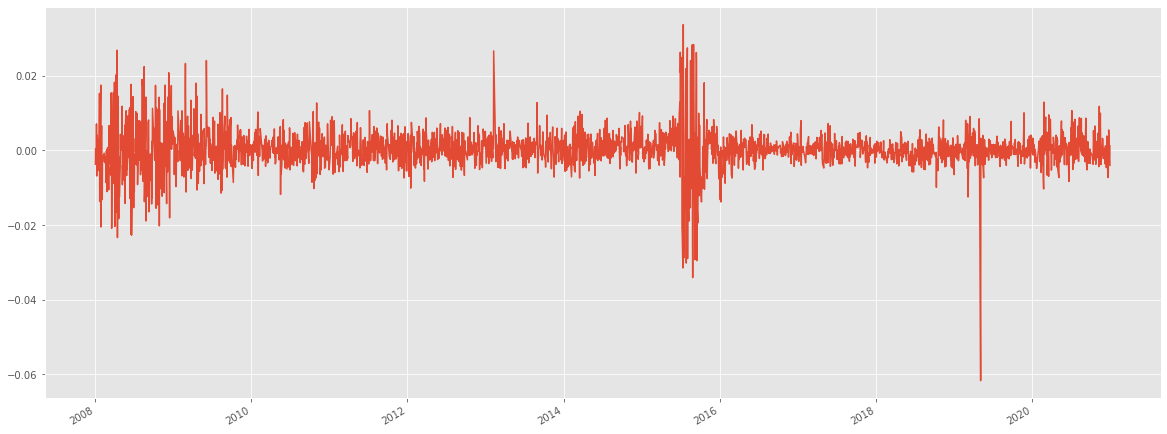

In [9]:
bab_daily.plot(figsize = (20,8))

In [10]:
def monthly_returns(df):
    """
    monthly returns
    """
    total_return_from_returns = lambda returns:(returns + 1).prod() - 1 # Returns the return between the first and last value of the DataFrame
    monthlyReturn = lambda series:series.groupby([series.index.year, series.index.month])\
    .apply(total_return_from_returns)

    monthlyReturnDF = df.apply(monthlyReturn, axis = 0)
    
    return monthlyReturnDF

In [11]:
monthly_rets_df = monthly_returns(df_rets)
monthly_rets_df 

300345    300414    603527    000830    601818    603690    300245  \
2008 1   0.000000  0.000000  0.000000 -0.000141  0.000000  0.000000  0.000000   
     2   0.000000  0.000000  0.000000  0.156198  0.000000  0.000000  0.000000   
     3   0.000000  0.000000  0.000000 -0.201359  0.000000  0.000000  0.000000   
     4   0.000000  0.000000  0.000000  0.077928  0.000000  0.000000  0.000000   
     5   0.000000  0.000000  0.000000  0.031212  0.000000  0.000000  0.000000   
...           ...       ...       ...       ...       ...       ...       ...   
2020 8  -0.007185  0.022494 -0.139236 -0.100394  0.011375 -0.110688  0.241200   
     9   0.022357 -0.075283 -0.088667 -0.124646 -0.052502 -0.099250 -0.161226   
     10 -0.375012  0.127199 -0.046454  0.110150  0.068754 -0.106833  0.062244   
     11 -0.167352 -0.106317  0.162753  0.234913  0.098311  0.104092 -0.096422   
     12 -0.181409 -0.197598 -0.203102 -0.003120 -0.085060  0.057725 -0.142287   

           300514    000930    601918  ...    600895    300448    300319  \
2008 1   0.000000 -0.017513  0.000000  ...  0.030080  0.000000  0.000000   
     2   0.000000  0.134681  0.000000  ...  0.010950  0.000000  0.000000   
     3   0.000000 -0.080109  0.000000  ... -0.158626  0.000000  0.000000   
     4   0.000000 -0.196550  0.000000  ... -0.227773  0.000000  0.000000   
     5   0.000000  0.077332  0.000000  ... -0.153001  0.000000  0.000000   
...           ...       ...       ...  ...       ...       ...       ...   
2020 8   0.074190  0.245379 -0.018606  ...  0.084096  0.086887 -0.046887   
     9  -0.058888 -0.185445 -0.055125  ... -0.146842 -0.043019 -0.153596   
     10  0.202767 -0.028484 -0.023373  ... -0.007699  0.114145 -0.048474   
     11 -0.044948  0.057120  0.177806  ... -0.027886 -0.084390  0.029522   
     12 -0.229493 -0.041451  0.065064  ... -0.090050 -0.193024 -0.094730   

           002553    002202    300548    300219    600995    002453    002302  
2008 1   0.000000  0.000000  0.000000  0.000000 -0.193215  0.000000  0.000000  
     2   0.000000  0.000000  0.000000  0.000000  0.123143  0.000000  0.000000  
     3   0.000000  0.000000  0.000000  0.000000 -0.247951  0.000000  0.000000  
     4   0.000000  0.000000  0.000000  0.000000  0.025896  0.000000  0.000000  
     5   0.000000  0.000000  0.000000  0.000000  0.072710  0.000000  0.000000  
...           ...       ...       ...       ...       ...       ...       ...  
2020 8  -0.020967 -0.154802 -0.156655  0.124892 -0.030012  0.114053  0.053171  
     9  -0.014845 -0.068934 -0.153236 -0.172281 -0.121639 -0.096411 -0.144886  
     10 -0.013041  0.112100  0.001858 -0.063211 -0.043611 -0.067681 -0.054036  
     11  0.251954  0.071921 -0.181769  0.083005  0.067782  0.058349  0.029444  
     12  0.128611  0.122513 -0.115563  0.021516 -0.009219  0.102633 -0.071820  

[156 rows x 3529 columns]

In [12]:
def portfolio_monthly(beta, monthlyReturnDF, rf = 0):
    betaRank = beta.rank(axis = 1) # same value: average their rank
    median = betaRank.mean(axis = 1) # average rank on each day
    k = 2 / abs(betaRank.subtract(median, axis = 0)).sum(axis = 1) # normalizing constant on each day
    w = betaRank.subtract(median, axis = 0).mul(k, axis = 0) # weight (+: high beta, -: low beta)
    
    tail = lambda x:x.tail(1)
    monthly = lambda x:x.groupby([x.index.year, x.index.month]).apply(tail)
    wMonthly = w.apply(monthly, axis = 0)
    betaMonthly = beta.apply(monthly, axis = 0)

    wMonthlyL = wMonthly.applymap(lambda x:-x if x < 0 else 0) # relative weight assigned to high beta
    wMonthlyH = wMonthly.applymap(lambda x:x if x > 0 else 0) # relative weight assigned to low beta


    monthlyIdx = wMonthly.index & betaMonthly.index
    monthlyReturnDFBaB = monthlyReturnDF.loc[monthlyIdx, ].shift(-1, axis = 0)


    portfolioMonthlyL = (monthlyReturnDFBaB.mul(wMonthlyL, axis = 1).sum(axis = 1) - rf) / (betaMonthly.mul(wMonthlyL, axis = 1).sum(axis = 1))
    portfolioMonthlyH = (monthlyReturnDFBaB.mul(wMonthlyH, axis = 1).sum(axis = 1) - rf) / (betaMonthly.mul(wMonthlyH, axis = 1).sum(axis = 1))
    portfolioMonthly = portfolioMonthlyL - portfolioMonthlyH
    
    # adjust index
    newIdx = pd.Index(list(portfolioMonthly.index)[1:])
    portfolioMonthly = portfolioMonthly[:-1,]

    portfolioMonthly.index = newIdx
    
    # reset index ( to datetime)
    portfolioMonthly.index = portfolioMonthly.index.droplevel([0,1]) 
    
    return portfolioMonthly

In [13]:
bab_monthly = portfolio_monthly(df_betas, monthly_rets_df)

In [14]:
bab_monthly.columns = ['monthly return']

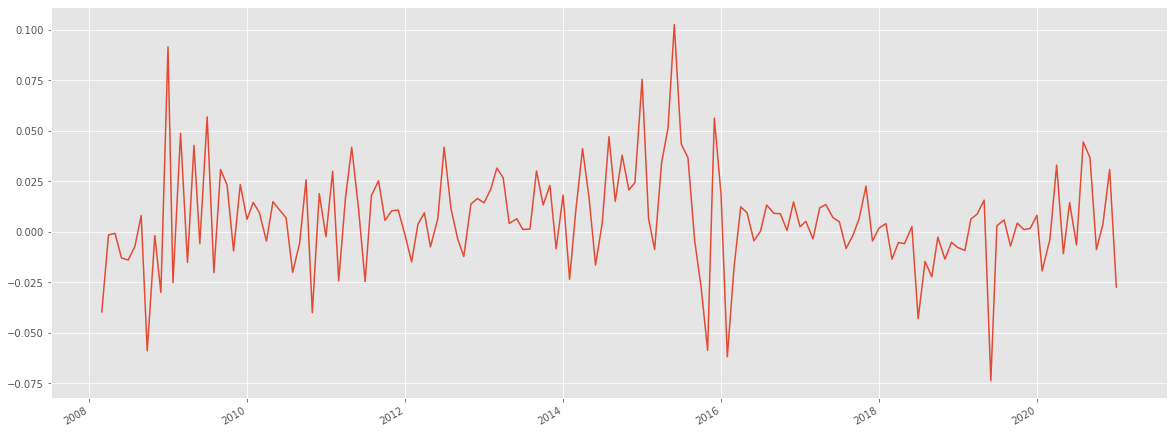

In [15]:
bab_monthly.plot(figsize = (20,8))

In [16]:
#### Equal-weighted BaB portfolio (monthly rebalancing) ####
def portfolio_monthly_equal_weighted(idx, beta, monthlyReturnDF):
    beta = beta.dropna(how = 'all', axis = 0)
    median = beta.mean(axis = 1) # average rank on each day
    
    # assign weight to those whose beta larger than mean
    compare_1 = lambda x: 1 if x else 0
    assign_1 = lambda x: (x > median).apply(compare_1)
    tmp_w = beta.apply(assign_1, axis = 0)
    
    avg = lambda x: x.divide(tmp_w.sum(axis = 1))
    wH = tmp_w.apply(avg, axis = 0)
    
    
    # assign weight to those whose beta lower than mean
    compare_2 = lambda x: 1 if x else 0
    assign_2 = lambda x: (x <= median).apply(compare_2)
    tmp_w = beta.apply(assign_2, axis = 0)
    
    avg_2 = lambda x: x.divide(tmp_w.sum(axis = 1))
    wL = tmp_w.apply(avg_2, axis = 0)
    
    w = wL - wH
    
    # monthly
    tail = lambda x:x.tail(1)
    
    monthly = lambda x:x.groupby([x.index.year, x.index.month]).apply(tail)
    wMonthly = w.apply(monthly, axis = 0)
    betaMonthly = beta.apply(monthly, axis = 0)

    # pick monthly return
    monthlyIdx = wMonthly.index & betaMonthly.index
    monthlyReturnDFBaB = monthlyReturnDF.loc[monthlyIdx, ].shift(-1, axis = 0)
    
    portfolioMonthly = (monthlyReturnDFBaB * wMonthly).sum(axis = 1)

    
    # adjust index
    newIdx = pd.Index(list(portfolioMonthly.index)[1:])
    portfolioMonthly = portfolioMonthly[:-1,]

    portfolioMonthly.index = newIdx
    
    # reset index ( to datetime)
    portfolioMonthly.index = portfolioMonthly.index.droplevel([0,1]) 
    
    return portfolioMonthly

In [17]:
#### Equal-weighted quantile portfolio (monthly rebalancing) ####
def portfolio_monthly_equal_weighted_quantile(beta, monthlyReturnDF):
    beta = beta.dropna(how = 'all', axis = 0)
    
    quantiles_portfolio = []
    betas_ex_ante = pd.DataFrame(index = ['Beta_ex_ante'])

    
    # assign weight to each quantile
    for idx,quantile in enumerate(np.arange(0,1,0.1),start = 1):
        low = beta.quantile(quantile, axis = 1)
        high = beta.quantile(quantile + 0.1, axis = 1)
        compare_1 = lambda x: 1 if x else 0
        assign_1 = lambda x: ((x >= low) & (x < high)).apply(compare_1)
        tmp_w = beta.apply(assign_1, axis = 0)
    
        avg = lambda x: x.divide(tmp_w.sum(axis = 1))
        w = tmp_w.apply(avg, axis = 0)
        
        #ex ante beta
        betas_ex_ante['P' + str(idx)] = (beta * w).sum(axis = 1).mean()
    
    
            # monthly
        tail = lambda x:x.tail(1)

        monthly = lambda x:x.groupby([x.index.year, x.index.month]).apply(tail)
        wMonthly = w.apply(monthly, axis = 0)

        betaMonthly = beta.apply(monthly, axis = 0)
        

        # pick monthly return
        monthlyIdx = wMonthly.index & betaMonthly.index
        monthlyReturnDFBaB = monthlyReturnDF.loc[monthlyIdx, ].shift(-1, axis = 0)

        portfolioMonthly = (monthlyReturnDFBaB * wMonthly).sum(axis = 1)


        # adjust index
        newIdx = pd.Index(list(portfolioMonthly.index)[1:])
        portfolioMonthly = portfolioMonthly[:-1,]

        portfolioMonthly.index = newIdx

        # reset index ( to datetime)
        portfolioMonthly.index = portfolioMonthly.index.droplevel([0,1])
        
        quantiles_portfolio.append(pd.DataFrame(portfolioMonthly, columns = ['P' + str(idx)]))
        print(idx)
    
    
    df_quantiles = reduce(lambda x,y:pd.merge(x,y,left_index=True, right_index=True),quantiles_portfolio)
        
        
    
    return df_quantiles, betas_ex_ante

In [18]:
df_quantiles, betas_ex_ante = portfolio_monthly_equal_weighted_quantile(df_betas, monthly_rets_df)
df_quantiles

1
2
3
4
5
6
7
8
9
10


,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10
2008-02-29,0.013006,0.031706,0.038380,0.064003,0.074654,0.091373,0.085702,0.092951,0.099620,0.085394
2008-03-31,-0.069687,-0.201073,-0.184631,-0.212123,-0.214665,-0.204795,-0.207173,-0.209562,-0.224839,-0.231121
2008-04-30,-0.022123,-0.068422,-0.072187,-0.061622,-0.081371,-0.086334,-0.076691,-0.078514,-0.076766,-0.072317
2008-05-30,-0.025841,-0.032404,-0.053991,-0.062134,-0.049914,-0.030051,-0.057552,-0.035883,-0.030027,-0.053369
2008-06-30,-0.127178,-0.237829,-0.247380,-0.269460,-0.278477,-0.267141,-0.280740,-0.279636,-0.290123,-0.296315
...,...,...,...,...,...,...,...,...,...,...
2020-08-31,0.036361,0.028649,0.032411,0.032408,0.039649,0.020749,0.030316,0.014343,0.011144,-0.011169
2020-09-30,-0.051829,-0.059397,-0.071740,-0.077620,-0.081611,-0.086246,-0.091538,-0.086610,-0.082588,-0.094286
2020-10-30,-0.005103,0.000725,-0.005086,0.003478,-0.007820,-0.015095,-0.009620,0.000632,-0.010484,-0.013933
2020-11-30,0.018208,0.031474,0.035723,0.023550,0.030102,0.027318,0.036815,0.017507,0.006307,-0.022409


In [24]:
## dont run this cell again
df_quantiles = df_quantiles.merge(df_rf_monthly, how = 'left', left_index = True, right_index = True).fillna(method='ffill')
df_quantiles = df_quantiles.sub(df_quantiles['Risk-free rate'].values, axis = 0)
df_quantiles = df_quantiles.drop('Risk-free rate', axis = 1)
df_quantiles

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10
2008-02-29,0.011027,0.029727,0.036401,0.062024,0.072675,0.089394,0.083723,0.090972,0.097640,0.083414
2008-03-31,-0.071575,-0.202961,-0.186519,-0.214011,-0.216553,-0.206683,-0.209061,-0.211450,-0.226727,-0.233009
2008-04-30,-0.024019,-0.070318,-0.074084,-0.063519,-0.083267,-0.088230,-0.078587,-0.080411,-0.078662,-0.074213
2008-05-30,-0.027919,-0.034482,-0.056069,-0.064212,-0.051992,-0.032128,-0.059630,-0.037961,-0.032105,-0.055446
2008-06-30,-0.129381,-0.240032,-0.249583,-0.271664,-0.280680,-0.269345,-0.282943,-0.281839,-0.292326,-0.298518
...,...,...,...,...,...,...,...,...,...,...
2020-08-31,0.034749,0.027037,0.030799,0.030796,0.038037,0.019137,0.028704,0.012731,0.009532,-0.012781
2020-09-30,-0.053520,-0.061089,-0.073432,-0.079311,-0.083302,-0.087937,-0.093230,-0.088302,-0.084280,-0.095977
2020-10-30,-0.007002,-0.001173,-0.006984,0.001580,-0.009718,-0.016993,-0.011518,-0.001266,-0.012382,-0.015831
2020-11-30,0.016541,0.029807,0.034056,0.021883,0.028435,0.025651,0.035148,0.015840,0.004640,-0.024076


In [25]:
df_quantiles['P11'] = (df_quantiles[['P1','P2','P3','P4','P5']].sum(axis = 1) - df_quantiles[['P6','P7','P8','P9','P10']].sum(axis=1))/5
df_quantiles['P12'] = bab_monthly
df_quantiles

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12
2008-02-29,0.011027,0.029727,0.036401,0.062024,0.072675,0.089394,0.083723,0.090972,0.097640,0.083414,-0.046658,-0.039715
2008-03-31,-0.071575,-0.202961,-0.186519,-0.214011,-0.216553,-0.206683,-0.209061,-0.211450,-0.226727,-0.233009,0.039062,-0.001558
2008-04-30,-0.024019,-0.070318,-0.074084,-0.063519,-0.083267,-0.088230,-0.078587,-0.080411,-0.078662,-0.074213,0.016979,-0.000768
2008-05-30,-0.027919,-0.034482,-0.056069,-0.064212,-0.051992,-0.032128,-0.059630,-0.037961,-0.032105,-0.055446,-0.003481,-0.012974
2008-06-30,-0.129381,-0.240032,-0.249583,-0.271664,-0.280680,-0.269345,-0.282943,-0.281839,-0.292326,-0.298518,0.050726,-0.014014
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,0.034749,0.027037,0.030799,0.030796,0.038037,0.019137,0.028704,0.012731,0.009532,-0.012781,0.020819,0.036779
2020-09-30,-0.053520,-0.061089,-0.073432,-0.079311,-0.083302,-0.087937,-0.093230,-0.088302,-0.084280,-0.095977,0.019814,-0.008838
2020-10-30,-0.007002,-0.001173,-0.006984,0.001580,-0.009718,-0.016993,-0.011518,-0.001266,-0.012382,-0.015831,0.006939,0.003827
2020-11-30,0.016541,0.029807,0.034056,0.021883,0.028435,0.025651,0.035148,0.015840,0.004640,-0.024076,0.014704,0.030887


In [26]:
### ex-ante betas
betas_ex_ante['P11'] = (betas_ex_ante[['P1','P2','P3','P4','P5']].sum(axis=1).values[0] - betas_ex_ante[['P6','P7','P8','P9','P10']].sum(axis=1).values[0])/5
betas_ex_ante['P12'] = 0
betas_ex_ante

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12
Beta_ex_ante,0.626345,0.878371,0.961679,1.019836,1.067021,1.109422,1.150639,1.195615,1.253256,1.367081,-0.304553,0


In [281]:
#df_quantiles_08_20 = df_quantiles
df_quantiles_09_20 = df_quantiles[(df_quantiles.index.year > 2008)]
df_quantiles_09_19 = df_quantiles[(df_quantiles.index.year > 2008) & (df_quantiles.index.year < 2020)]

In [438]:
### Select the time frame to use for df_quantiles
df_quantiles = df_quantiles_08_20

In [447]:
df_quantiles_08_20.to_csv('../output/China/Portfolio monthly returns/08-20.csv')
df_quantiles_09_20.to_csv('../output/China/Portfolio monthly returns/09-20.csv')
df_quantiles_08_19.to_csv('../output/China/Portfolio monthly returns/08-19.csv')

In [441]:
def df_portfolios_summary(df_quantiles, df_factors):
    
    df_excess_ret = pd.DataFrame(df_quantiles.mean() * 100).T 
    df_excess_ret.columns = ['P' + str(i) for i in range(1,13)]
    df_excess_ret.index = ['Excess return']
    
    model_data = df_quantiles.merge(df_factors, left_index = True, right_index = True)
    model_data.columns = ['P' + str(i) for i in range(1,13)] +['MKT','SMB','HML','RMW','CMA']
    
    df_capm =  pd.DataFrame(index = ['CAPM alpha'])
    df_three_factors_alpha =  pd.DataFrame(index = ['Three-factor alpha'])
    df_four_factors_alpha =  pd.DataFrame(index = ['Four-factor alpha'])
    df_five_factors_alpha =  pd.DataFrame(index = ['Five-factor alpha'])
    beta_realized =  pd.DataFrame(index = ['Beta (realized)'])
    
    for idx in [i for i in range(1,13)]:

        exog = model_data[['MKT']]
        exog = sm.add_constant(exog)
        endog = model_data['P' + str(idx)]
        # Fit and summarize OLS model
        mod = sm.OLS(endog, exog)

        res = mod.fit()
        df_capm['P' + str(idx)] = res.params[0] * 100
        
    for idx in np.arange(1,13):

        exog = model_data[['MKT','SMB','HML']]
        exog = sm.add_constant(exog)
        endog = model_data['P' + str(idx)]
        # Fit and summarize OLS model
        mod = sm.OLS(endog, exog)

        res = mod.fit()
        df_three_factors_alpha['P' + str(idx)] = res.params[0] * 100

    for idx in np.arange(1,13):

        exog = model_data[['MKT','SMB','HML','RMW']]
        exog = sm.add_constant(exog)
        endog = model_data['P' + str(idx)]
        # Fit and summarize OLS model
        mod = sm.OLS(endog, exog)

        res = mod.fit()
        df_four_factors_alpha['P' + str(idx)] = res.params[0] * 100

    for idx in np.arange(1,13):

        exog = model_data[['MKT','SMB','HML','RMW','CMA']]
        exog = sm.add_constant(exog)
        endog = model_data['P' + str(idx)]
        # Fit and summarize OLS model
        mod = sm.OLS(endog, exog)
        res.tvalues
        res = mod.fit()
        df_five_factors_alpha['P' + str(idx)] = res.params[0] * 100
        
    for idx in np.arange(1,13):

        exog = model_data[['MKT']]
        exog = sm.add_constant(exog)
        endog = model_data['P' + str(idx)]
        # Fit and summarize OLS model
        mod = sm.OLS(endog, exog)

        res = mod.fit()
        beta_realized['P' + str(idx)] = res.params.loc['MKT'] * 0.5 + 0.5
        
    df_volatility = pd.DataFrame(df_quantiles.std()*np.sqrt(12)* 100, columns = ['Volatility']).T
    df_volatility.columns = ['P' + str(i) for i in range(1,13)]
    
    df_rets_quantiles = pd.DataFrame((((1+df_quantiles).cumprod().iloc[-1])**(12/len(df_quantiles)) - 1) * 100).T
    df_SR = df_excess_ret * 12 / df_volatility.values
    df_SR.columns = ['P' + str(i) for i in range(1,13)]
    df_SR.index = ['Sharpe Ratio']
    
    
    portfolio_summary = pd.concat([df_excess_ret,df_capm,df_three_factors_alpha,df_four_factors_alpha,df_five_factors_alpha,betas_ex_ante,beta_realized,df_volatility,df_SR])
    portfolio_summary = portfolio_summary.applymap(lambda x: np.round(x,3)) 
    portfolio_summary = portfolio_summary.rename(columns = {'P11':'bab (equally-weighted)', 'P12':'bab (beta-weighted)'})
    portfolio_summary = portfolio_summary.applymap(lambda x: np.round(x,2))
    
    return portfolio_summary


    

In [442]:
df_portfolios_summary(df_quantiles, df_factors)

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,bab (equally-weighted),bab (beta-weighted)
Excess return,0.14,0.06,-0.02,-0.04,0.08,-0.07,-0.13,-0.44,-0.64,-1.04,0.51,0.62
CAPM alpha,0.09,-0.51,-0.59,-0.77,-0.70,-0.88,-0.97,-1.30,-1.56,-1.91,0.83,0.89
Three-factor alpha,-0.17,-0.99,-1.07,-1.30,-1.26,-1.47,-1.56,-1.88,-2.16,-2.48,0.95,0.87
Four-factor alpha,-0.14,-0.95,-1.04,-1.23,-1.20,-1.38,-1.47,-1.71,-2.00,-2.35,0.87,0.80
Five-factor alpha,-0.14,-0.94,-1.04,-1.23,-1.20,-1.38,-1.48,-1.71,-2.00,-2.34,0.87,0.80
Beta_ex_ante,0.63,0.88,0.96,1.02,1.07,1.11,1.15,1.20,1.25,1.37,-0.30,0.00
Beta (realized),0.76,0.97,0.98,1.00,1.02,1.03,1.03,1.03,1.05,1.07,0.40,0.53
Volatility,17.91,29.04,29.73,31.14,32.65,33.37,34.10,34.42,35.52,36.88,9.26,8.73
Sharpe Ratio,0.09,0.02,-0.01,-0.02,0.03,-0.02,-0.05,-0.16,-0.22,-0.34,0.66,0.84


In [437]:
#portfolio_summary.iloc[1:5].drop('bab (equally-weighted)', axis = 1).to_latex('China_tvalues_09-20.tex')

In [358]:
#### Monthly cumulative return between specified start and end date ####
def portfolio_monthly_cum_ret(portfolioMonthly, start, end):
    portfolioMonthly = portfolioMonthly.drop(index = portfolioMonthly.idxmin())  # after dropping the downside outlier
    portfolioMonthly = portfolioMonthly.drop(index = portfolioMonthly.idxmax())  # after dropping the downside outlier
    
    # filter date
    portfolioMonthly = portfolioMonthly.loc[(portfolioMonthly.index > start) & (portfolioMonthly.index < end)]
    
    # cumulative return
    portfolioMonthlyCum = (1 + portfolioMonthly).cumprod()
    # add 1 (initial investment) to the first row
    firstDate = portfolioMonthlyCum.index[0] - pd.Timedelta(days = portfolioMonthly.index[0].day - 1)
    first = pd.Series([initialInvest], index = [firstDate])
    portfolioMonthlyCum = pd.concat([first, portfolioMonthlyCum])
    
    return pd.DataFrame(portfolioMonthlyCum)

In [295]:
#### to csv #####
def to_csv_cum_ret(resultPath, name, data, method):
    resultName = name + '_' +  method + '.csv'
    data.index.name = 'Date'
    data.columns = data.columns
    data.to_csv(resultPath + '/' +  resultName)

In [191]:
## output the results
to_csv_cum_ret(resultPath = '../data/Chinese BAB results', name = 'daily BAB', data = bab_daily, method = 'daily rebalancing')
to_csv_cum_ret(resultPath = '../data/Chinese BAB results', name = 'montly BAB', data = bab_monthly, method = 'monthly rebalancing')
to_csv_cum_ret(resultPath = '../data/Chinese BAB results', name ='quantile return' , data = df_quantiles, method = 'monthly rebalancing equally weighted')
to_csv_cum_ret(resultPath = '../data/Chinese BAB results', name = 'quantile portoflios summary ', data = portofolio_summary , method = 'monthly rebalancing equally weighted')

In [296]:
def summary_plot(portfolio_summary):
    fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize = (45,30))
    
    for idx,index in enumerate(portfolio_summary.index):
        
        axs[idx//3,idx%3].bar(portfolio_summary.loc[index].index,portfolio_summary.loc[index], color = 'steelblue')
        props = {
            'title': index,
            'xlabel': 'Portfolio',
            'ylabel': index,
        }
        axs[idx//3,idx%3].set(**props)
        axs[idx//3,idx%3].set_xticklabels(portfolio_summary.columns, rotation = 10);
        
   

###  Chinese factor premium cummulative returns vs annual return

In [449]:
def plot_cum_return(df, column = None, premium_type = None):
    
    fig, axs = plt.subplots(2,1,figsize = (16,12))
    
    df = df[[column]][df.index.year > 2007]
    
    ((1+df).cumprod()-1).plot(title = 'Cummulative return of risk premium of ' + premium_type, ax = axs[0])
    axs[0].set_xlabel('Year')
    axs[0].set_ylabel('Cummulative return')
    
    df['Year'] = df.index.year
    
    df.groupby('Year')[column].apply(lambda x: (1+x).cumprod().tail(1) - 1).droplevel(1).plot(kind = 'bar')
    axs[1].set_xlabel('Year')
    axs[1].set_ylabel('Annual Return')
    
    
    

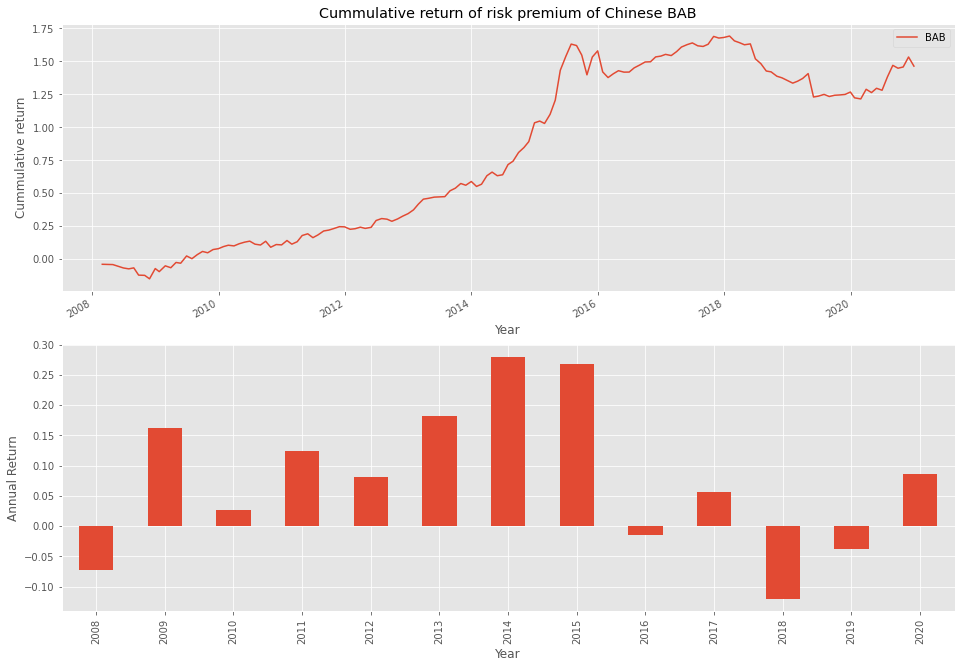

In [506]:
plot_cum_return(pd.DataFrame(bab_monthly,columns = ['BAB']), column = 'BAB', premium_type = 'Chinese BAB')
plt.savefig('../output/China/Graphs/cumulative excess returns factors/bab.pdf', dpi = 400)

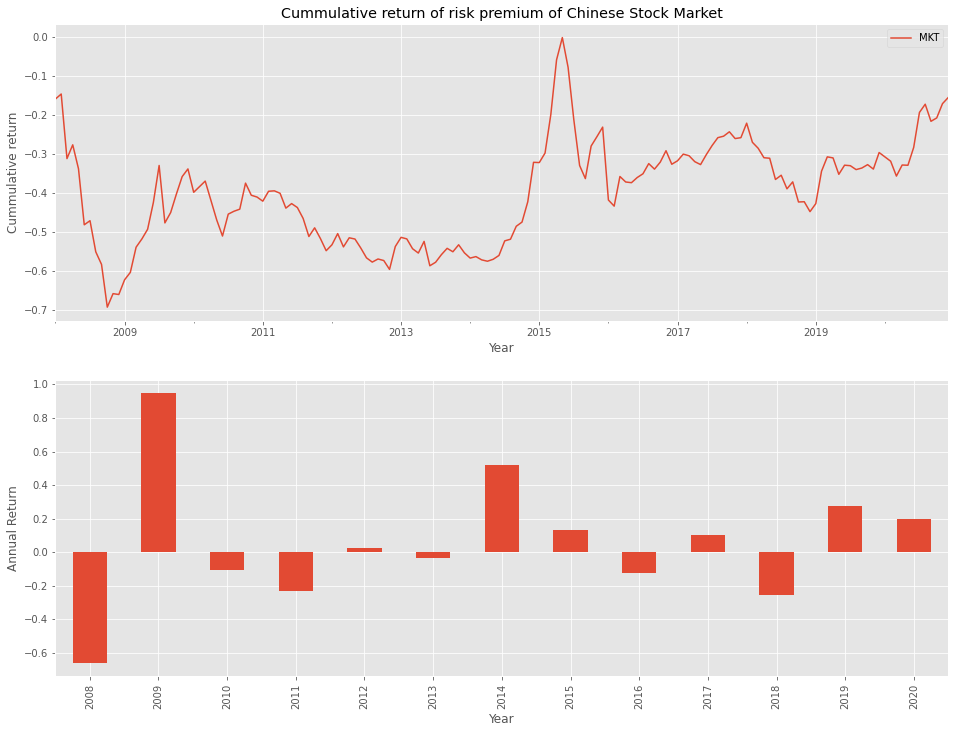

In [517]:
plot_cum_return(df_factors[df_factors.index.year<2021],column = 'MKT', premium_type = 'Chinese Stock Market')
plt.savefig('../output/China/Graphs/cumulative excess returns factors/mkt.pdf', dpi = 400)

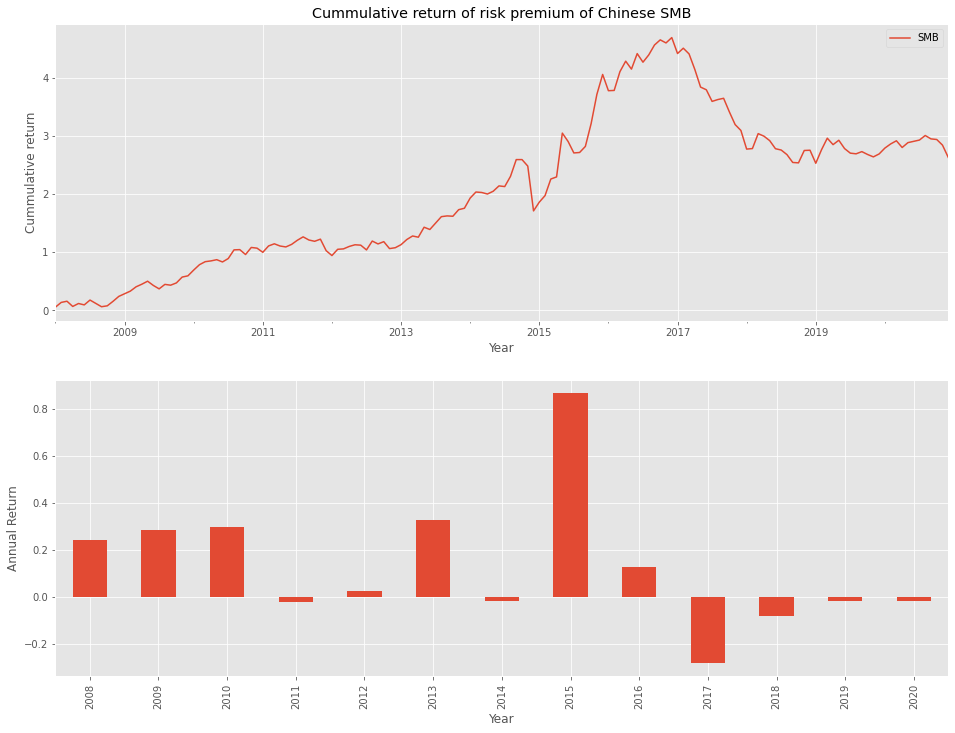

In [518]:
plot_cum_return(df_factors[df_factors.index.year<2021],column = 'SMB', premium_type = 'Chinese SMB')
plt.savefig('../output/China/Graphs/cumulative excess returns factors/smb.pdf', dpi = 400)

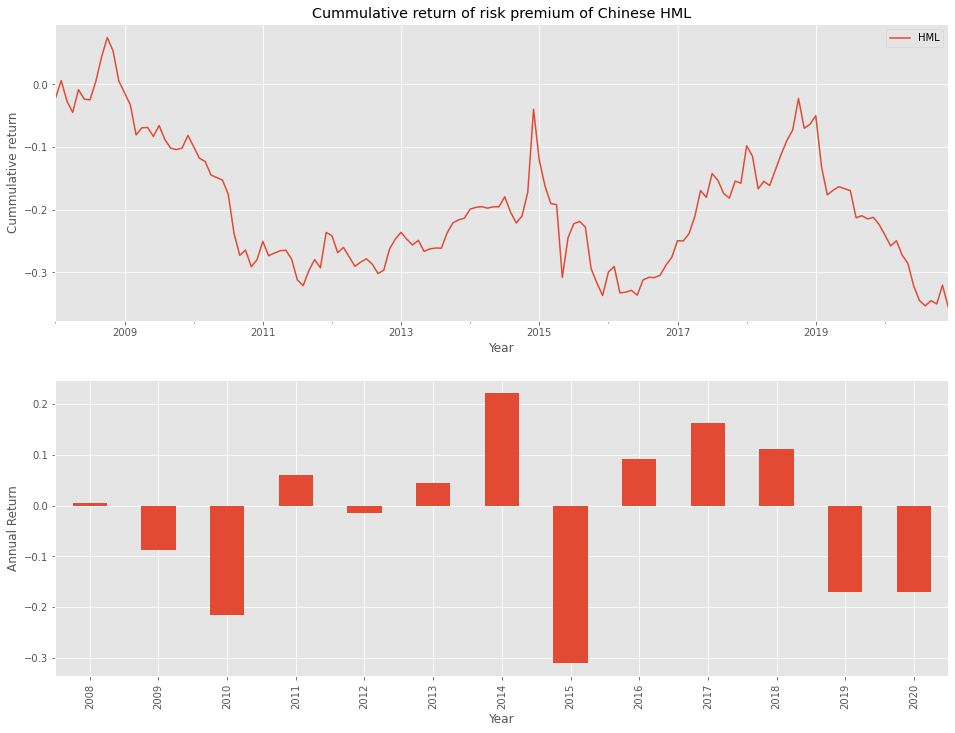

In [509]:
plot_cum_return(df_factors[df_factors.index.year<2021],column = 'HML', premium_type = 'Chinese HML')
plt.savefig('../output/China/Graphs/cumulative excess returns factors/hml.pdf', dpi = 400)

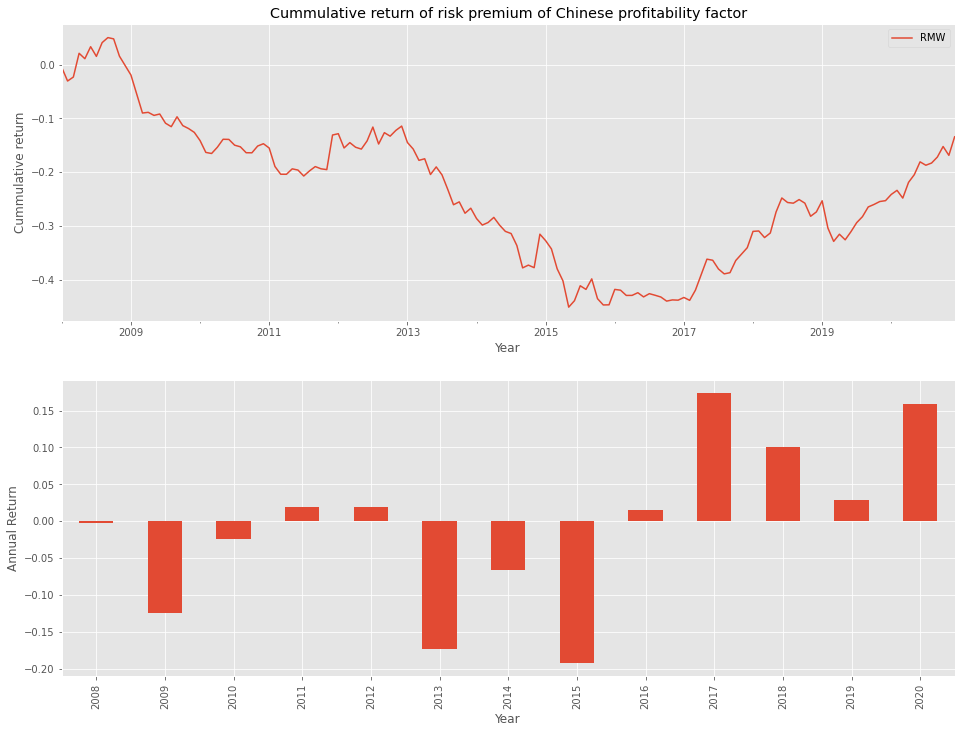

In [510]:
plot_cum_return(df_factors[df_factors.index.year<2021],column = 'RMW', premium_type = 'Chinese profitability factor')
plt.savefig('../output/China/Graphs/cumulative excess returns factors/rmw.pdf', dpi = 400)

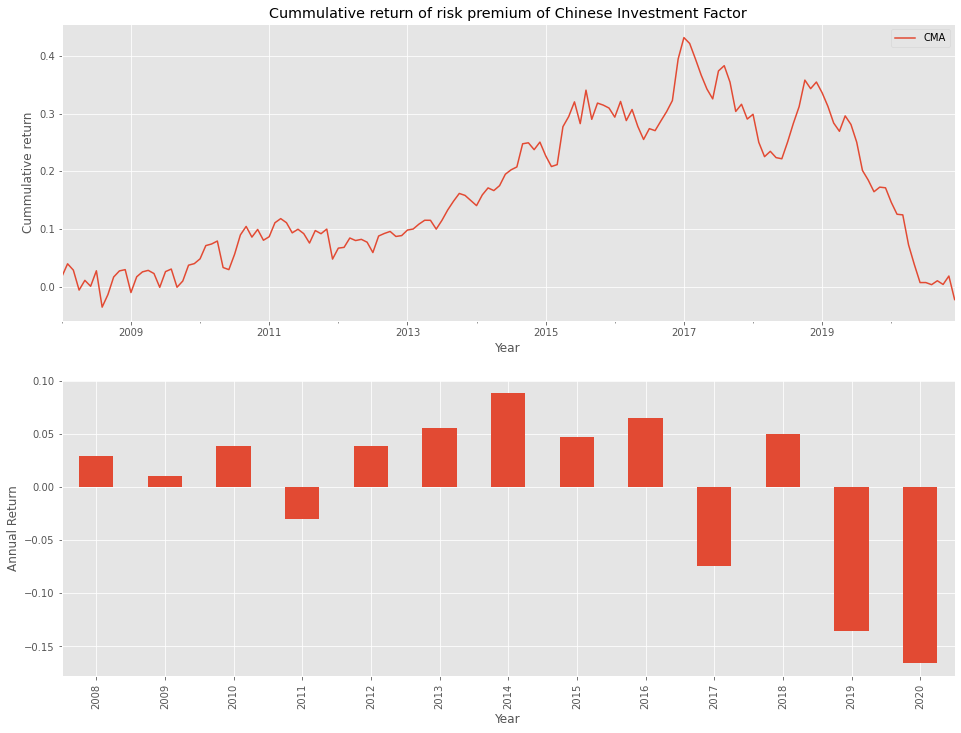

In [511]:
plot_cum_return(df_factors[df_factors.index.year<2021],column = 'CMA', premium_type = 'Chinese Investment Factor')
plt.savefig('../output/China/Graphs/cumulative excess returns factors/cma.pdf', dpi = 400)

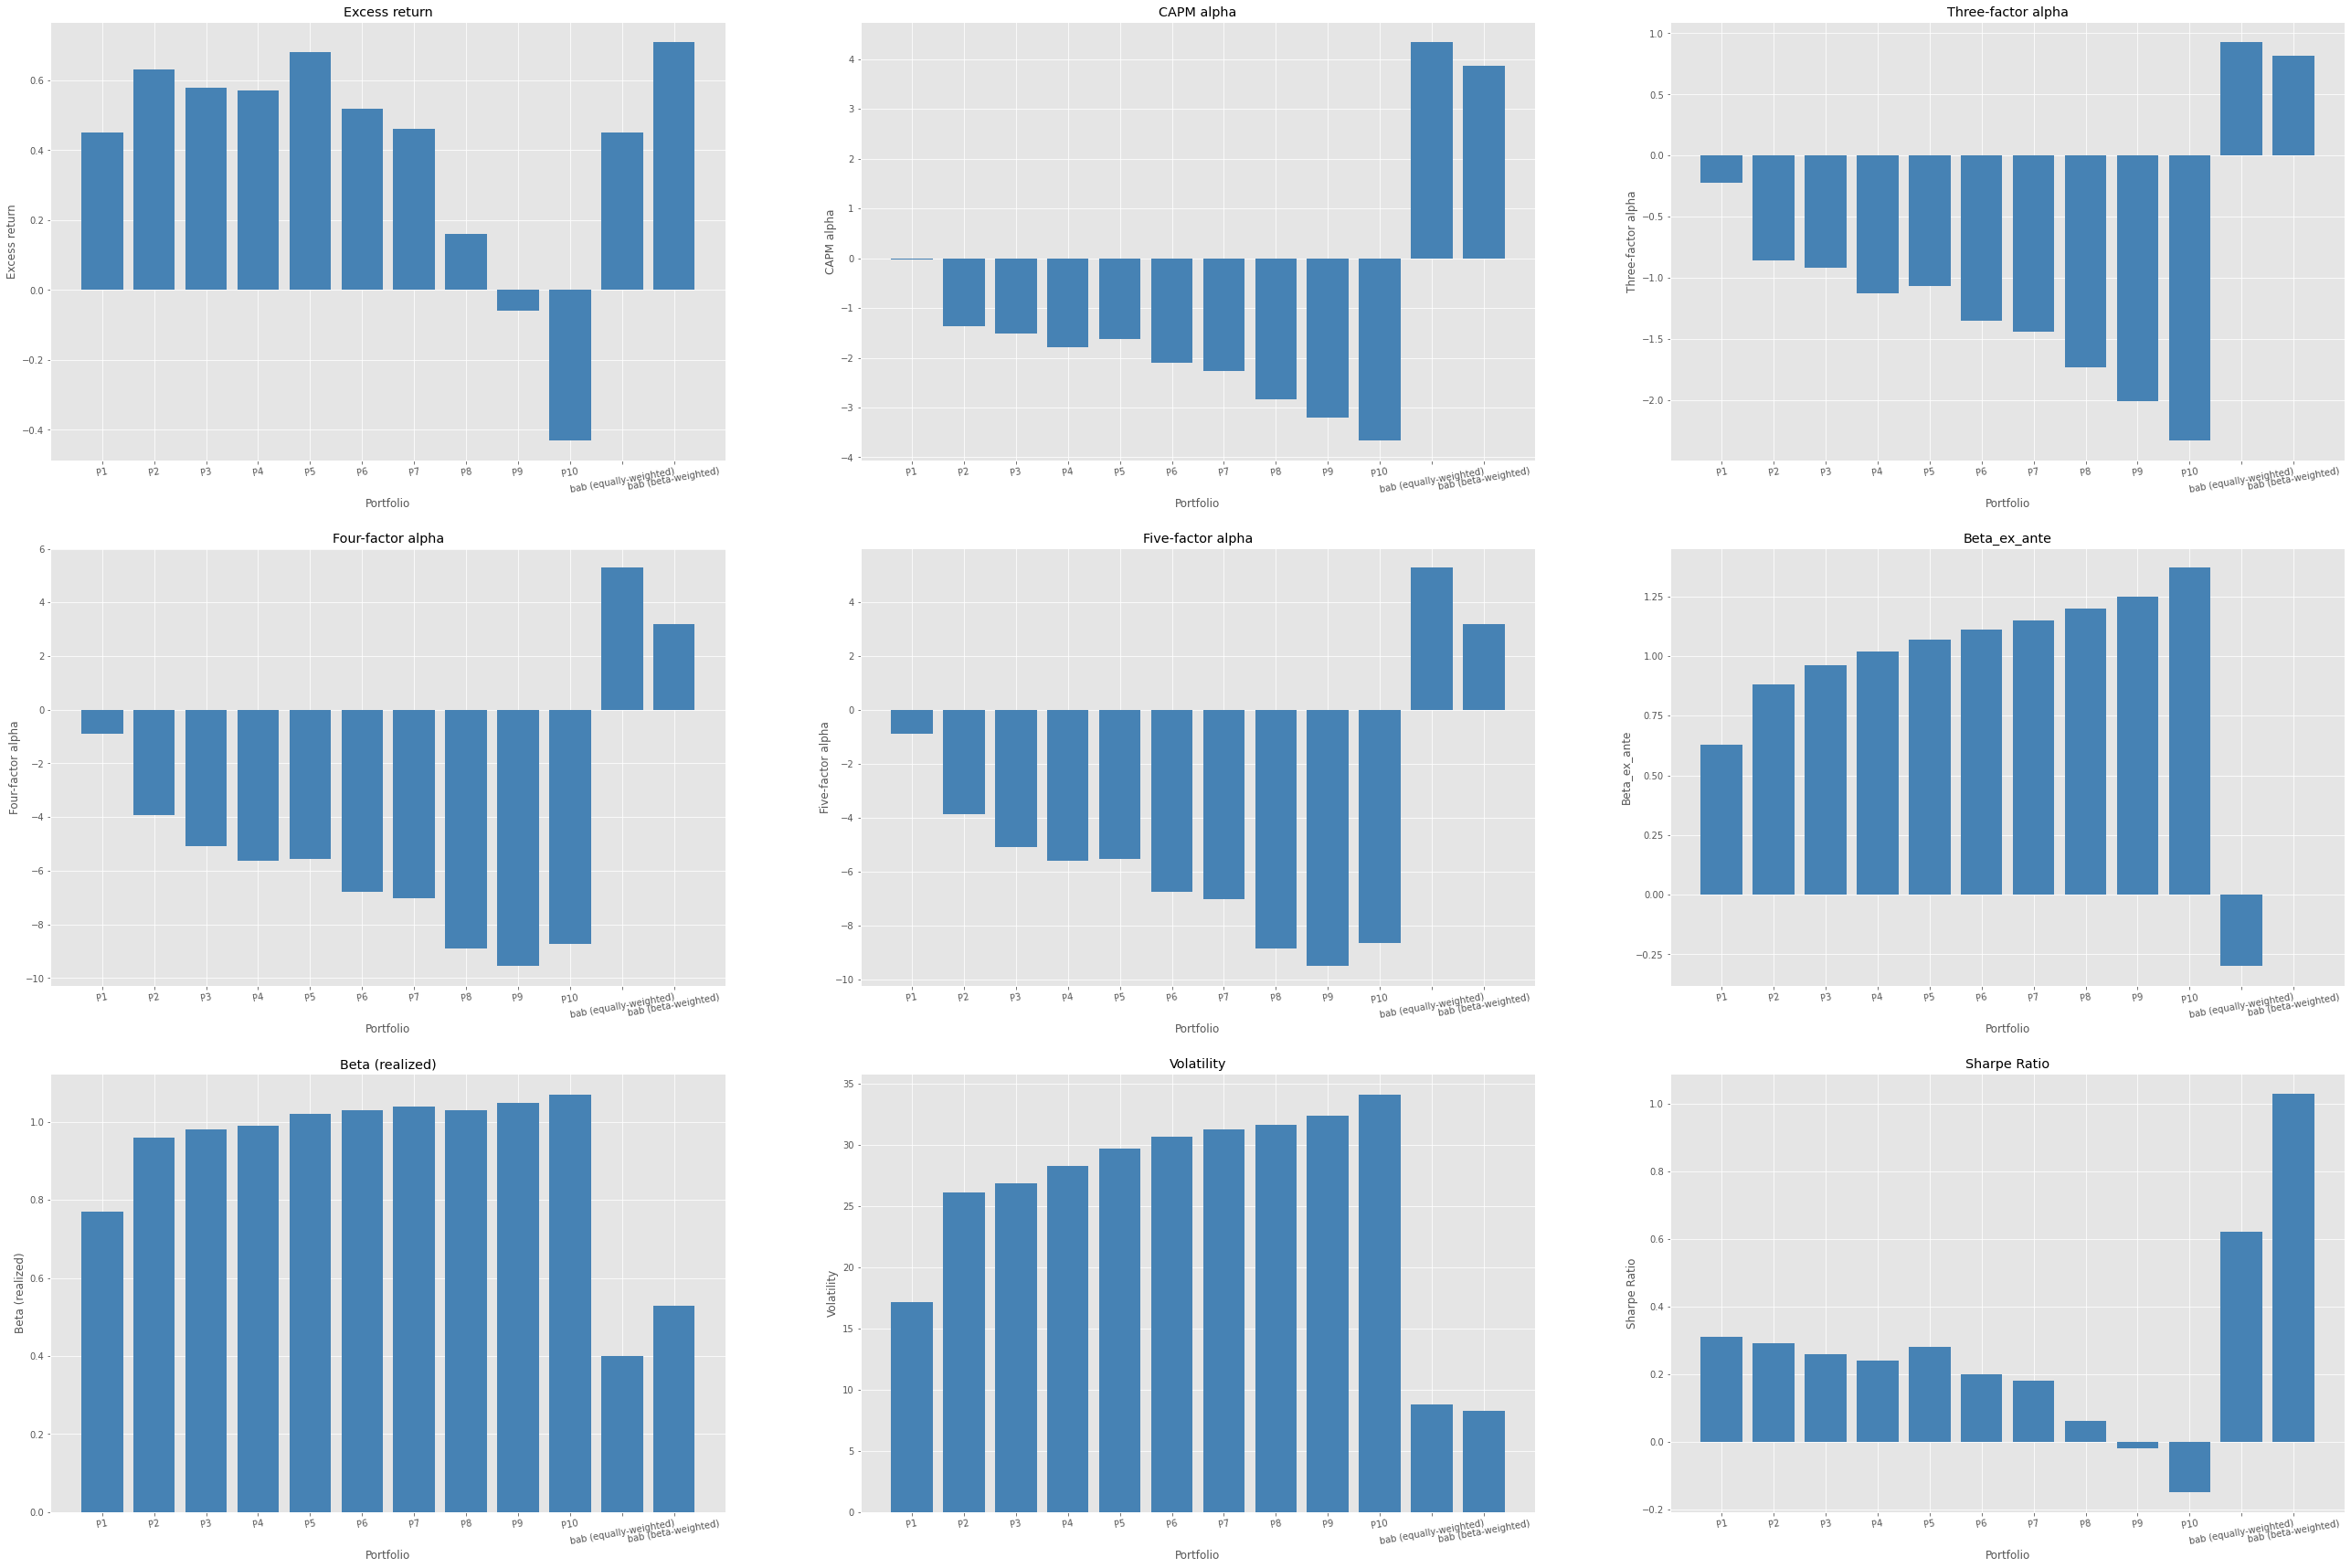

In [512]:
summary_plot(portfolio_summary)
plt.savefig('../output/China/Graphs/portfolio_summary.pdf', dpi = 400)

In [477]:
df_quantiles

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12
Date,,,,,,,,,,,,
2008-02-29,0.011027,0.029727,0.036401,0.062024,0.072675,0.089394,0.083723,0.090972,0.097640,0.083414,-0.046658,-0.039715
2008-03-31,-0.071575,-0.202961,-0.186519,-0.214011,-0.216553,-0.206683,-0.209061,-0.211450,-0.226727,-0.233009,0.039062,-0.001558
2008-04-30,-0.024019,-0.070318,-0.074084,-0.063519,-0.083267,-0.088230,-0.078587,-0.080411,-0.078662,-0.074213,0.016979,-0.000768
2008-05-30,-0.027919,-0.034482,-0.056069,-0.064212,-0.051992,-0.032128,-0.059630,-0.037961,-0.032105,-0.055446,-0.003481,-0.012974
2008-06-30,-0.129381,-0.240032,-0.249583,-0.271664,-0.280680,-0.269345,-0.282943,-0.281839,-0.292326,-0.298518,0.050726,-0.014014
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,0.034749,0.027037,0.030799,0.030796,0.038037,0.019137,0.028704,0.012731,0.009532,-0.012781,0.020819,0.036779
2020-09-30,-0.053520,-0.061089,-0.073432,-0.079311,-0.083302,-0.087937,-0.093230,-0.088302,-0.084280,-0.095977,0.019814,-0.008838
2020-10-30,-0.007002,-0.001173,-0.006984,0.001580,-0.009718,-0.016993,-0.011518,-0.001266,-0.012382,-0.015831,0.006939,0.003827


In [531]:
def factors_loading(df_quantiles,df_factors):
    fig, axs = plt.subplots(4,3, figsize = (30,40),sharey = True)
    
    df_quantiles = df_quantiles.drop('P11',axis = 1)
    
    model_data = df_quantiles.merge(df_factors, left_index = True, right_index = True)
    model_data.columns = ['P' + str(i) for i in range(1,11)] + ['bab (beta-weighted)'] +['MKT','SMB','HML','RMW','CMA']
    
    for idx, column in enumerate(['P' + str(i) for i in range(1,11)] + ['bab (beta-weighted)']):
        data = model_data[[column,'MKT','SMB','HML','RMW','CMA']].copy()
        data['const'] = 1

        #fit
        model = RollingOLS(endog =data[column].values , exog = data[['const','MKT','SMB','HML','RMW','CMA']],window=30)
        rres = model.fit()
        
        rres.params.iloc[:,1:].plot(ax = axs[idx//3,idx%3])
        axs[idx//3,idx%3].set_title(column + ' Rolling beta')
        axs[idx//3,idx%3].set_xlabel('Year', fontsize=18)
        axs[idx//3,idx%3].set_ylabel('Beta', fontsize=18)
        axs[idx//3,idx%3].tick_params(axis='both', which='major', labelsize=15)
        


In [ ]:
factors_loading(df_quantiles,df_factors)
plt.savefig('../output/China/Graphs/portfolios rolling beta.png', dpi = 200)

In [305]:
import seaborn as sns

In [306]:
bab_yearly = pd.DataFrame(bab_monthly)
bab_yearly.index.name = 'Date'
bab_yearly.columns = ['return']
bab_yearly['Year'] = bab_yearly.index.year
bab_yearly = bab_yearly.groupby('Year')['return'].apply(lambda x: (1+x).cumprod().iloc[-1] - 1)
bab_yearly = pd.DataFrame(bab_yearly)
bab_yearly = bab_yearly.reset_index()
bab_yearly 

,Year,return
0,2008,-0.072223
1,2009,0.162755
2,2010,0.026586
3,2011,0.123656
4,2012,0.080770
5,2013,0.181213
6,2014,0.280394
7,2015,0.268484
8,2016,-0.015400
9,2017,0.055643


In [307]:
df_portfolios = df_quantiles.copy()
df_portfolios = df_portfolios.rename(columns = {'P11':'bab (equally-weighted)','P12':'bab (beta-weighted)' })
df_portfolios

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,bab (equally-weighted),bab (beta-weighted)
Date,,,,,,,,,,,,
2009-01-23,0.069588,0.173114,0.169466,0.193322,0.222899,0.216503,0.231675,0.226711,0.218400,0.233464,-0.059673,-0.025197
2009-02-27,0.061756,0.085318,0.089254,0.077027,0.070090,0.077801,0.060516,0.061367,0.060000,0.048658,0.015020,0.048832
2009-03-31,0.089791,0.189286,0.155082,0.189927,0.192467,0.215639,0.219265,0.229064,0.238669,0.229589,-0.063135,-0.015220
2009-04-30,0.066018,0.055164,0.044170,0.056161,0.052952,0.074510,0.049003,0.037402,0.026418,0.040907,0.009245,0.042762
2009-05-27,0.021026,0.054271,0.046863,0.069769,0.073490,0.060049,0.061621,0.077032,0.068264,0.070228,-0.014355,-0.005860
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-31,0.034749,0.027037,0.030799,0.030796,0.038037,0.019137,0.028704,0.012731,0.009532,-0.012781,0.020819,0.036779
2020-09-30,-0.053520,-0.061089,-0.073432,-0.079311,-0.083302,-0.087937,-0.093230,-0.088302,-0.084280,-0.095977,0.019814,-0.008838
2020-10-30,-0.007002,-0.001173,-0.006984,0.001580,-0.009718,-0.016993,-0.011518,-0.001266,-0.012382,-0.015831,0.006939,0.003827


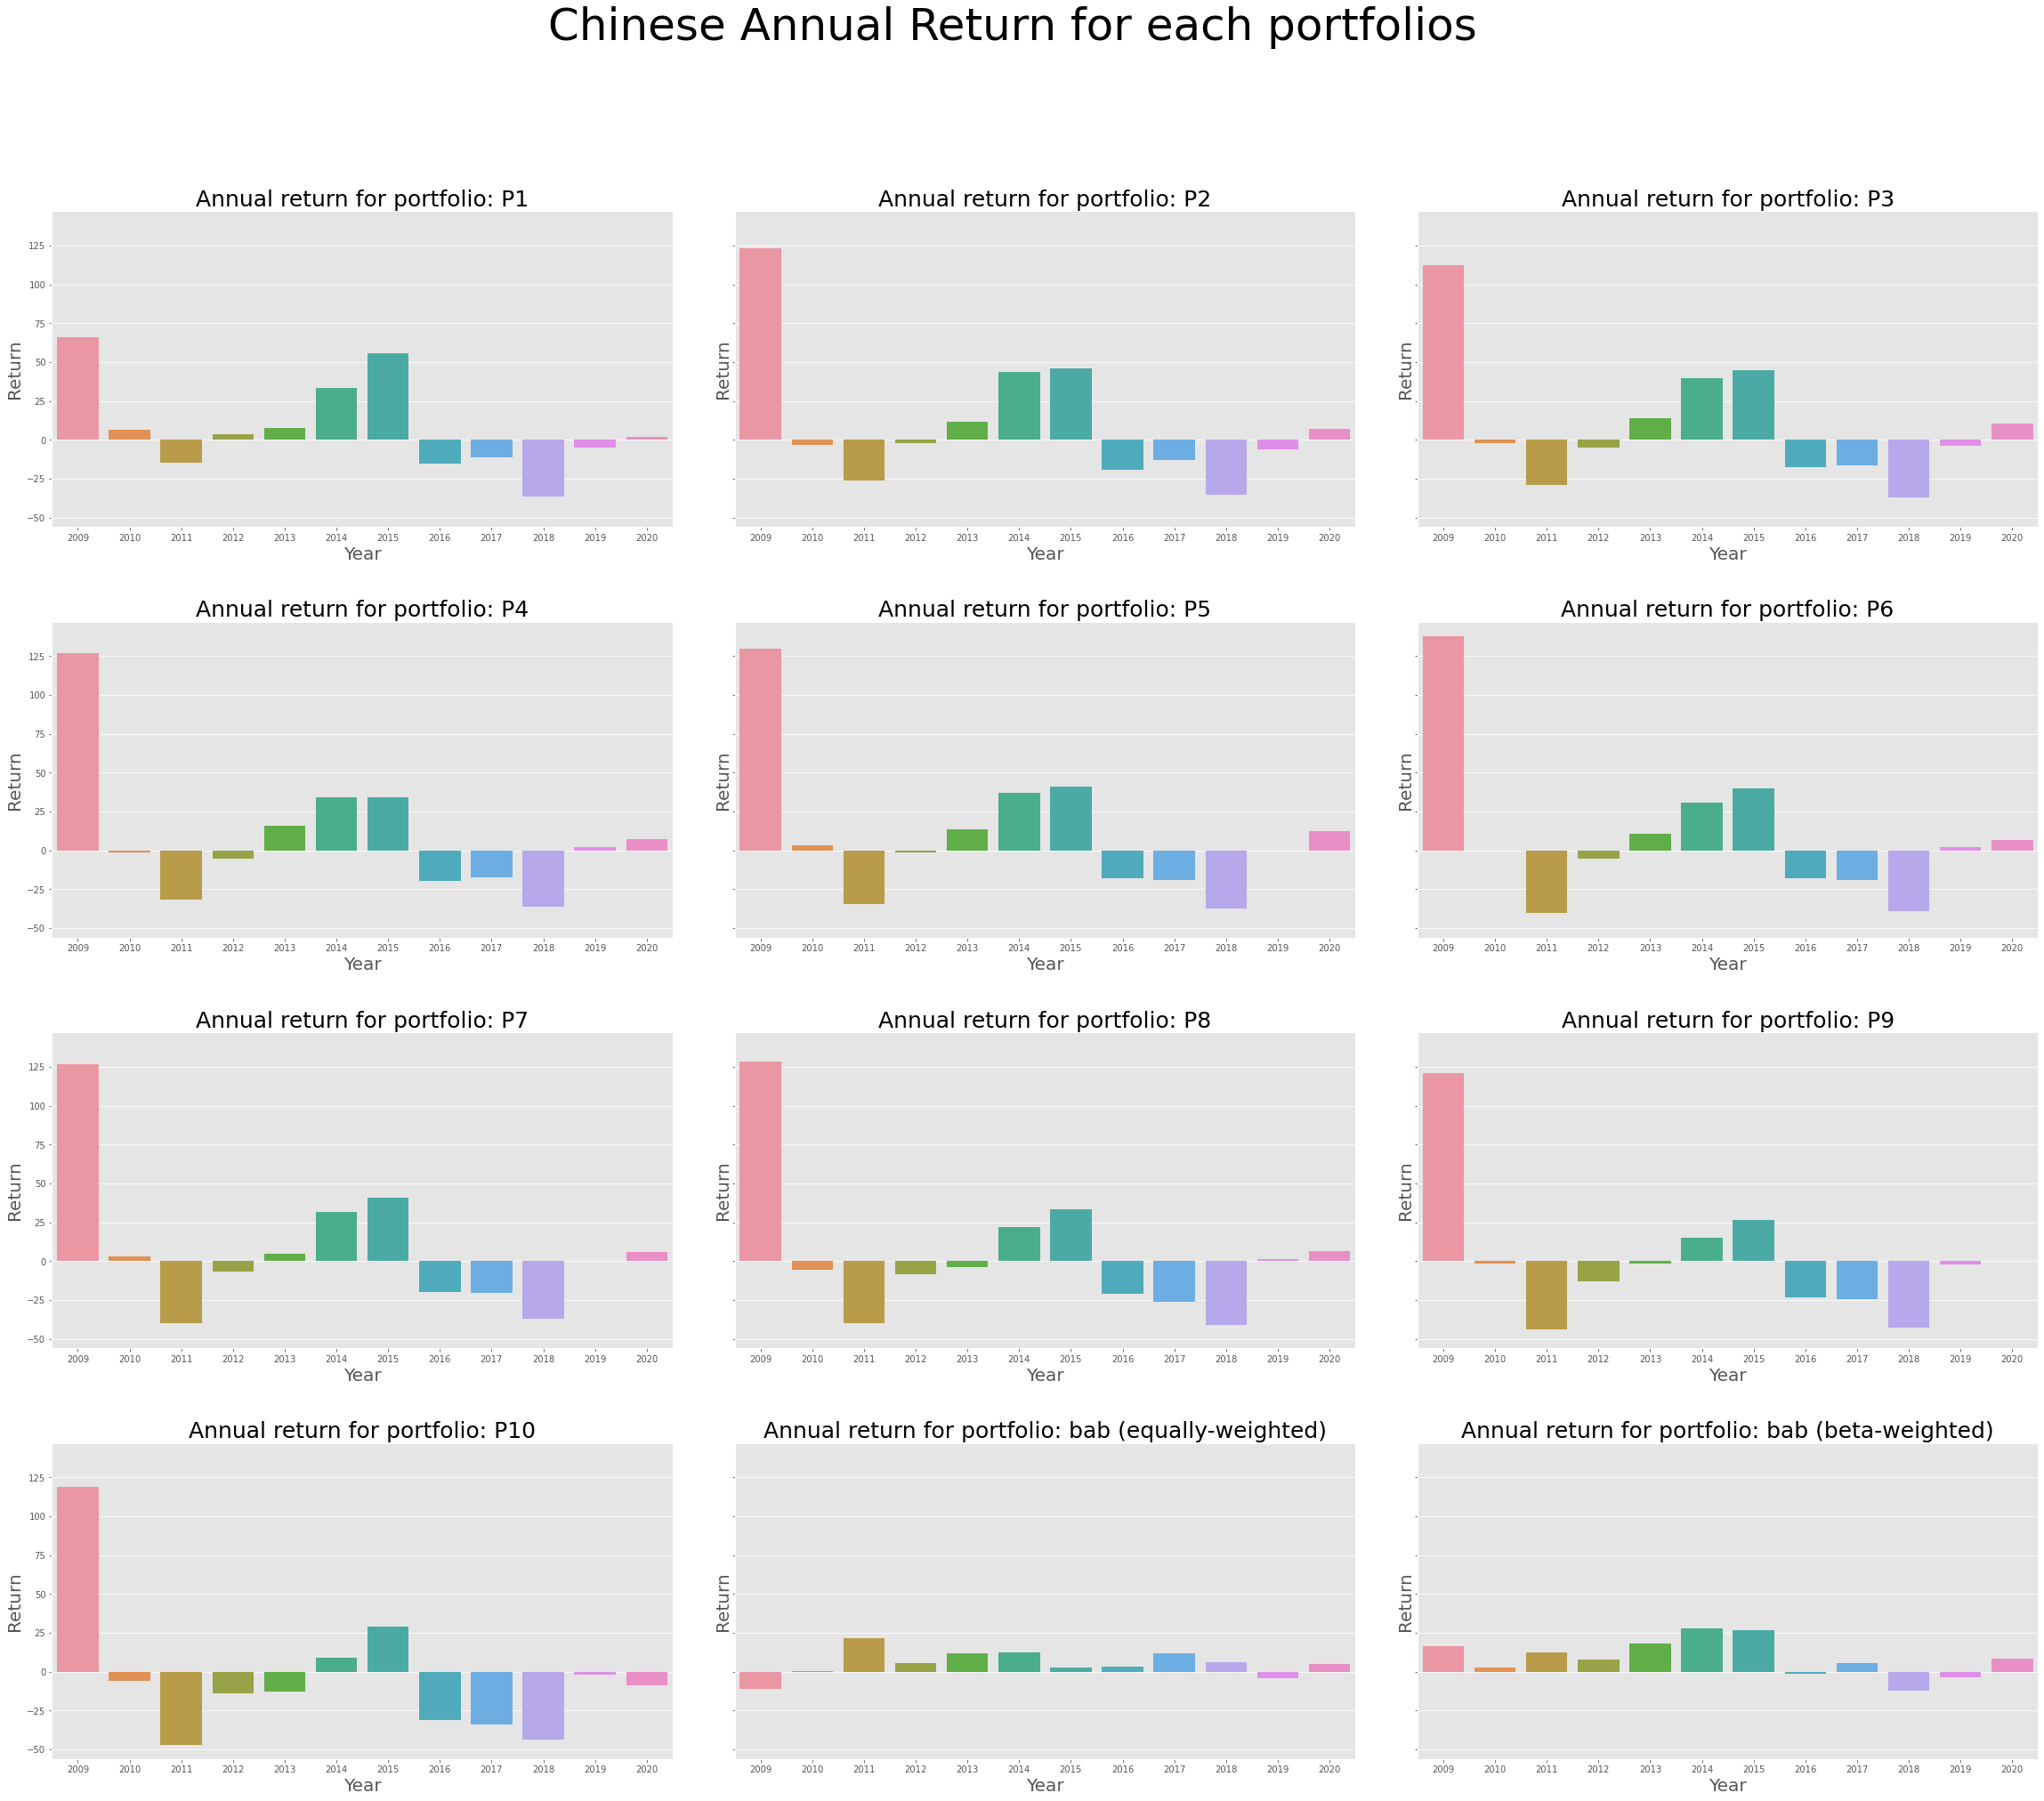

In [308]:
fig, axs = plt.subplots(4,3,figsize = (40,32), sharey = True)

fig.suptitle('Chinese Annual Return for each portfolios', fontsize = 50)
for idx,portfolio in enumerate(df_portfolios.columns):
    portfolio_yearly = pd.DataFrame(df_portfolios[portfolio])
    portfolio_yearly.index.name = 'Date'
    portfolio_yearly.columns = ['return']
    portfolio_yearly['Year'] = portfolio_yearly.index.year
    portfolio_yearly = portfolio_yearly.groupby('Year')['return'].apply(lambda x: (1+x).cumprod().iloc[-1] - 1)
    portfolio_yearly = pd.DataFrame(portfolio_yearly * 100)
    portfolio_yearly = portfolio_yearly.reset_index()
    sns.barplot(x = 'Year', y = 'return', data = portfolio_yearly, ci = False, ax = axs[idx//3,idx%3])
    axs[idx//3,idx%3].set_title('Annual return for portfolio: ' + portfolio, fontsize=25)
    axs[idx//3,idx%3].set_xlabel('Year', fontsize = 20)
    axs[idx//3,idx%3].set_ylabel('Return', fontsize = 20)

plt.subplots_adjust(wspace = 0.1, hspace = 0.3)

fig.savefig("../output/China/Graphs/Chinese Annual Return for each portfolio.pdf", bbox_inches='tight', dpi = 400)    

In [309]:
portoflio_summary.applymap(lambda x : np.round(x,2)).drop('bab (equally-weighted)', axis = 1).to_latex('China_summary_08-20.tex')